## ETK Filtering

In [10]:
import Simulator
import Observation
import Statistics
import IEWParticleFilter

## Loading simulator 

For Kalman filtering we have to be able to propagate a Gaussian distribution in time and to have access to the linear operators

In [11]:
timestamp = "2021_08_26-12_22_18"

grid, simulator = Simulator.from_file(timestamp)

## Definition of initial distribution 

The inital state is equipped with a Gaussian distribution specified by its mean and covariance. 

In [12]:
statistics = Statistics.Statistics(simulator, N_e=5000)

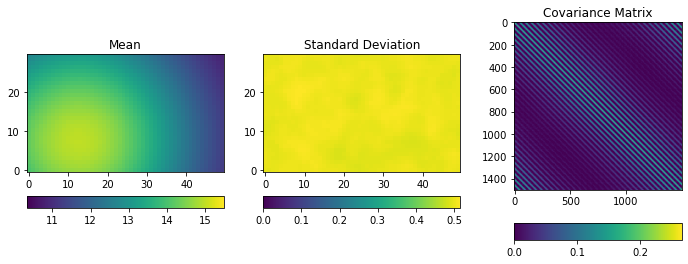

In [13]:
prior_args = Statistics.prior_args_from_file(timestamp)
statistics.set_prior(prior_args)

statistics.plot()

## Loading observations 

Observation positions which are fixed for a setup and values from the truth

In [14]:
obs_timestamp = "2021_08_26-12_22_28"
observation = Observation.from_file(grid, timestamp, obs_timestamp)

Remember to set observation positions and to set/observe values!


## IEWPF filtering

Updating/conditioning the distributions at every observation time

In [15]:
import numpy as np

ensemble_beforeDA = np.zeros((11,grid.N_x,statistics.ensemble.N_e))
ensemble_afterDA = np.zeros((11,grid.N_x,statistics.ensemble.N_e))

ensemble_beforeDA[0] = statistics.ensemble.ensemble
ensemble_afterDA[0] = statistics.ensemble.ensemble

0


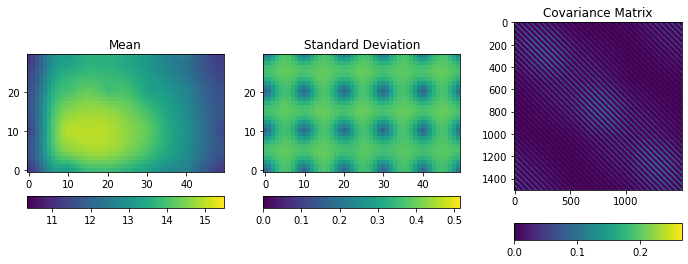

1


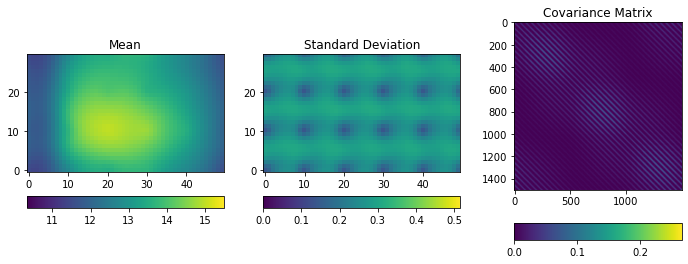

2


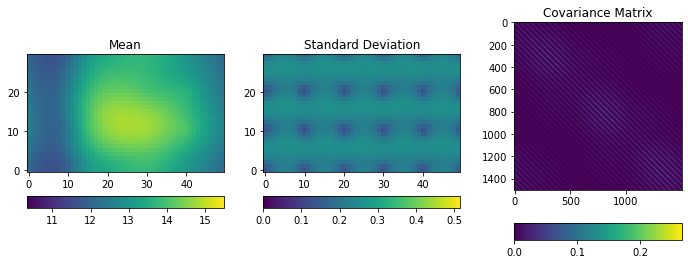

3


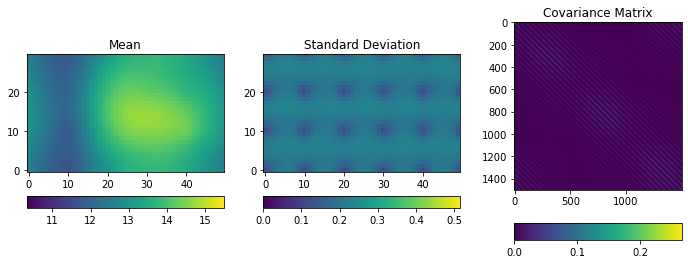

4


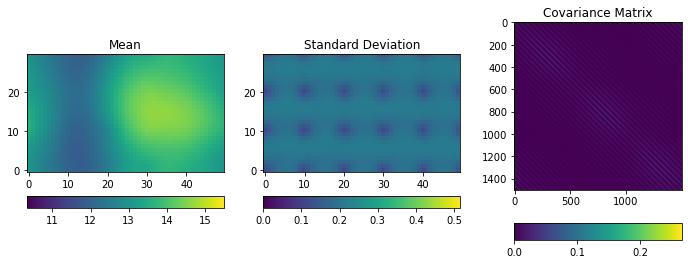

5


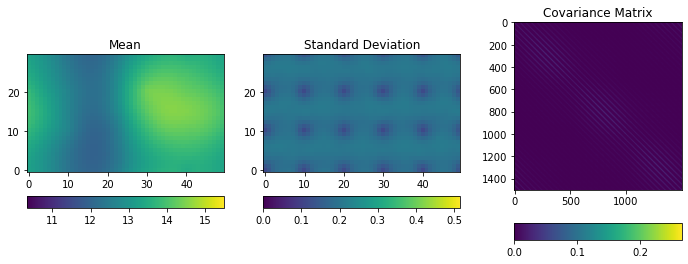

6


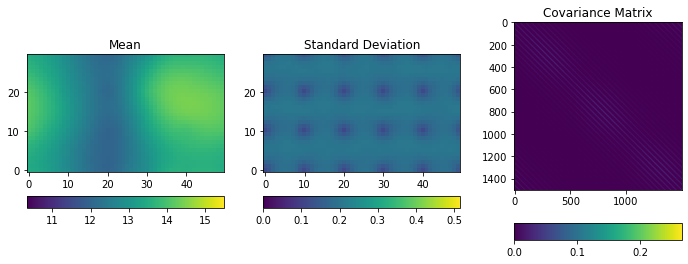

7


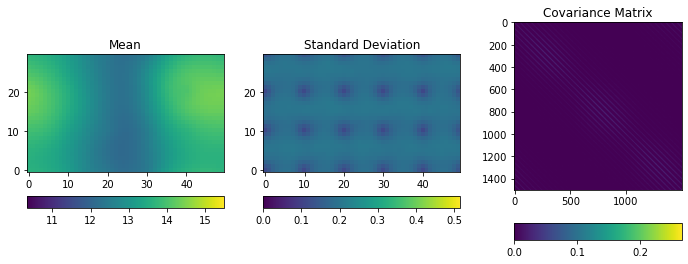

8


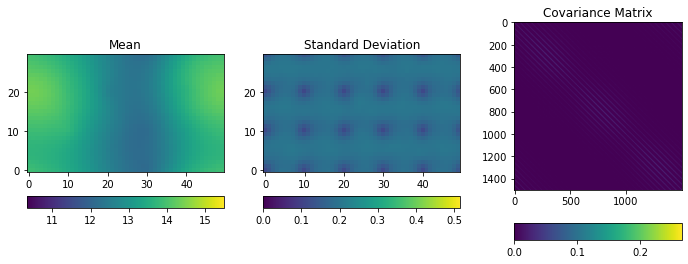

9


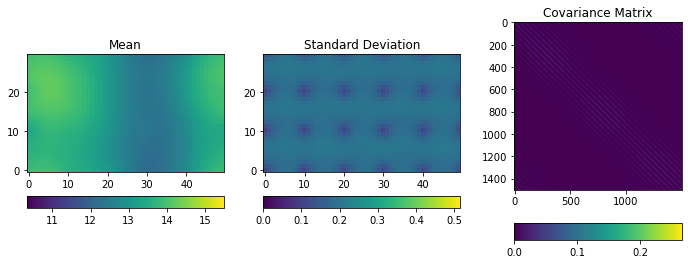

[0.7941849658269091, 0.8250189447357885, 0.9278191659344704, 0.9487471185524042, 0.9532867566114483, 0.9752464326690173, 0.9723735409068531, 0.9774181576755128, 0.9820195543177329, 0.9749025921172646]


In [16]:
iewpFilter = IEWParticleFilter.IEWParticle(statistics, observation)

for t in range(observation.N_obs):
    print(t)
    statistics.propagate(25, model_error=False)
    ensemble_beforeDA[t+1] = statistics.ensemble.ensemble
    iewpFilter.filter(statistics.ensemble.ensemble, observation.obses[t])
    ensemble_afterDA[t+1]  = statistics.ensemble.ensemble
    statistics.plot()

print(iewpFilter.betas)

## Correlation Study

In [17]:
points = [[20,10],[29,13]]

indicator_field1 = np.zeros((grid.ny, grid.nx))
indicator_field1[points[0][1],points[0][0]] = 1.0
idx1 = np.where(indicator_field1.flatten() != 0 )[0][0]

indicator_field2 = np.zeros((grid.ny, grid.nx))
indicator_field2[points[1][1],points[1][0]] = 1.0
idx2 = np.where(indicator_field2.flatten() != 0 )[0][0]

In [18]:
timestep = 5

mean_point1 = np.average(ensemble_afterDA[timestep][idx1])
mean_point2 = np.average(ensemble_beforeDA[timestep+1][idx2])

stddev_point1 = np.std(ensemble_afterDA[timestep][idx1])
stddev_point2 = np.std(ensemble_beforeDA[timestep+1][idx2])

cov_point2point = 1/(statistics.ensemble.N_e-1) * (ensemble_afterDA[timestep][idx1] - mean_point1) @ (ensemble_beforeDA[timestep+1][idx2] - mean_point2)

corr_point2point = cov_point2point/(stddev_point1*stddev_point2)
corr_point2point

0.32662707841568067